Uncomment the following lines if running on Google Colaboratory. This will install versions of PyTorch and CuPy that work with our package, and then download the package files from the GitHub repo.

Restart the runtime when prompted to in the output of the cell.

In [ ]:
# !pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install cupy-cuda110
# !git clone https://github.com/BouazzaSE/NeuralXVA
# !mv NeuralXVA/* ./
# !rm -R NeuralXVA

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from learning.cva_estimator_portfolio_int import CVAEstimatorPortfolioInt
from learning.cva_estimator_portfolio_def import CVAEstimatorPortfolioDef
from simulation.diffusion_engine import DiffusionEngine
import time
import torch
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = '100'

In [2]:
np.random.seed(0)
torch.manual_seed(0)

In [3]:
torch.backends.cudnn.benchmark = False # don't allow cudnn to tune for every input size
torch.backends.cudnn.enabled = True

## Simulation parameters

* `num_coarse_steps`: # of coarse time-steps, *ie* steps at which we price and learn;
* `dT`: size of a coarse time-step (uniform time-stepping), should be equal to the simulation horizon in years divided by `num_coarse_steps`;
* `num_fine_per_coarse`: # of fine time-steps per coarse time-step, those are steps through which the numerical diffusions are stepping;
* `dt`: should be equal to `dT/num_fine_per_coarse`;
* `num_paths`: # of diffusion paths ($M$ in the article);
* `num_inner_paths`: # of inner-paths for the Nested Monte Carlo benchmark, set to `1` if no NMC benchmark is needed;
* `num_defs_per_path`: # of default simulations given each diffusion path ($N$ in the article);
* `num_rates`: # of economies, each represented by a 1-factor short-rate;
* `num_spreads`: # of counterparties + 1, with one stochastic spread for each counterparty and one for the bank itself;
* `R`: correlation matrix, should be `2*num_rates-1+num_spreads` by `2*num_rates-1+num_spreads`;

As for the order in which the stochastic diffusion factors are stored, the first `num_rates` components are the short-rates, the next `num_rates-1` are the associated cross-currency exchange rates against the reference currency (which is assumed to be the first, *ie* with id 0), and the last `num_spreads` are the stochastic intensity processes where the first one is for the bank and the rest are for the counterparties.

As for the diffusion parameters, they can be set using the following correspondence with the notation in Appendix B of the article:
* `rates_params['a'][e]` $\leftrightarrow a^{\langle e\rangle}$;
* `rates_params['b'][e]` $\leftrightarrow b^{\langle e\rangle}$;
* `rates_params['sigma'][e]` $\leftrightarrow \sigma^{r, \langle e\rangle}$;
* `fx_params['vol'][e]` $\leftrightarrow \sigma^{\chi, \langle e\rangle}$;
* `spreads_params['a'][c]` $\leftrightarrow \alpha^{\langle c\rangle}$;
* `spreads_params['b'][c]` $\leftrightarrow \delta^{\langle c\rangle}$;
* `spreads_params['vvol'][c]` $\leftrightarrow \nu^{\langle c\rangle}$;

Finally, for the products, one can set them in their `specs` arrays below. We invite the user to see the pricing functions in `compile_cuda_diffuse_and_price` (simulation/kernels.py) for more details on how the product specifications are used.

In the following, we fill the diffusion parameters and the product specs randomly.

In [23]:
num_coarse_steps = 100
dT = 0.1
num_fine_per_coarse = 25
dt = 0.004
num_paths = 2**15
num_inner_paths = 1024
num_defs_per_path = 256
num_rates = 10
num_spreads = 9
R = np.eye(2*num_rates-1+num_spreads, dtype=np.float32) # we set the correlation matrix to the identity matrix, although not needed
initial_values = np.empty(2*num_rates-1+num_spreads, dtype=np.float32)
initial_defaults = np.empty((num_spreads-1+7)//8, dtype=np.int8)

# rates diffusion parameters
rates_params = np.empty(num_rates, dtype=[('a', '<f4'), ('b', '<f4'), ('sigma', '<f4')])
rates_params['a'] = np.random.normal(0.4, 0.03, num_rates)
rates_params['b'] = np.random.normal(0.03, 0.001, num_rates)
rates_params['sigma'] = np.abs(np.random.normal(0.0025, 0.00025, num_rates))
initial_values[:num_rates] = 0.01

# FX diffusion parameters
fx_params = np.empty(num_rates-1, dtype=[('vol', '<f4')])
fx_params['vol'] = np.abs(np.random.normal(0.25, 0.025, num_rates-1))
initial_values[num_rates:2*num_rates-1] = 1

# stochastic intensities diffusion parameters
spreads_params = np.empty(num_spreads, dtype=[('a', '<f4'), ('b', '<f4'), ('vvol', '<f4')])
spreads_params['a'] = np.random.normal(0.5, 0.03, num_spreads)
spreads_params['b'] = np.random.normal(0.01, 0.001, num_spreads)
spreads_params['vvol'] = np.abs(np.random.normal(0.0075, 0.00075, num_spreads))
initial_values[2*num_rates-1:] = 0.01

# initial default indicators
initial_defaults[:] = 0

# length of simulated path on the GPU (paths are then simulated by chunks of cDtoH_freq until maturity)
cDtoH_freq = 20

# product specs (DO NOT use the ZCs)
num_vanillas = 0
vanilla_specs = np.empty(num_vanillas,
                         dtype=[('maturity', '<f4'), ('notional', '<f4'),
                                ('strike', '<f4'), ('cpty', '<i4'),
                                ('undl', '<i4'), ('call_put', '<b1')])

num_irs = 500
irs_specs = np.empty(num_irs,
                     dtype=[('first_reset', '<f4'), ('reset_freq', '<f4'),
                            ('notional', '<f4'), ('swap_rate', '<f4'),
                            ('num_resets', '<i4'), ('cpty', '<i4'),
                            ('undl', '<i4')])

irs_specs['first_reset'] = 0.  # First reset date in the swaps
irs_specs['reset_freq'] = 0.2  # Reset frequency
irs_specs['notional'] = 10000. * \
    ((np.random.choice((-1, 1), num_irs, p=(0.5, 0.5)))
     * np.random.choice(range(1, 11), num_irs))  # Notional of the swaps
irs_specs['swap_rate'] = np.abs(np.random.normal(0.03, 0.001, num_irs))  # Swap rate, not needed, swaps are priced at par anyway
irs_specs['num_resets'] = np.random.randint(6, 51, num_irs, np.int32)  # Number of resets (num_resets*reset_freq should be equal to the desired maturity)
irs_specs['cpty'] = np.random.randint(0, num_spreads-1, num_irs, np.int32)  # Counterparty with which the swap was entered into
irs_specs['undl'] = np.random.randint(0, num_rates-1, num_irs, np.int32)  # Underlying currency

num_zcs = 0
zcs_specs = np.empty(num_zcs,
                     dtype=[('maturity', '<f4'), ('notional', '<f4'),
                            ('cpty', '<i4'), ('undl', '<i4')])

Next, we select the GPU. Should be `cuda:0` if there is only one GPU available. This is where both the simulation and the training/inference are going to be performed.

In [5]:
device = torch.device('cuda:0')

We then instantiate the diffusion engine and the estimators (one with default indicators and the other with default intensities).

In [7]:
diffusion_engine = DiffusionEngine(50, 50, num_coarse_steps, dT, num_fine_per_coarse, dt,
                                   num_paths, num_inner_paths, num_defs_per_path, 
                                   num_rates, num_spreads, R, rates_params, fx_params, 
                                   spreads_params, vanilla_specs, irs_specs, zcs_specs,
                                   initial_values, initial_defaults, cDtoH_freq, device.index)

# selector for previous swap resets, need the states at those dates because of how the small non-Markovianity in the swap prices
prev_reset_arr = (np.arange(num_coarse_steps+1)-1)//2*2

# learner with default indicators
cva_estimator_portfolio_def = CVAEstimatorPortfolioDef(prev_reset_arr, True, False, False, diffusion_engine, 
                                                       device, 1, 2*(num_rates+num_spreads), (num_defs_per_path*num_paths)//32, 
                                                       8, 0.01, 0, reset_weights=False, linear=False, best_sol=True)

# learner with default intensities
cva_estimator_portfolio_int = CVAEstimatorPortfolioInt(prev_reset_arr, True, False, False, diffusion_engine, 
                                                       device, 1, 2*(num_rates+num_spreads), (num_defs_per_path*num_paths)//32, 
                                                       8, 0.01, 0, reset_weights=False, linear=False, best_sol=True)

Successfully compiled all kernels.


## Training

We launch a first set of simulations in order to have paths on which to train on. This will simulate the risk factors and do all the pricings at the coarse time-steps.

In [18]:
diffusion_engine.generate_batch(fused=True)

cuda_diffuse_and_price elapsed time: 896.563 ms


We create a generator for the feature and tell it to keep the data in CUDA memory and implicitly copy when assigning to Numpy arrays, and then we launch the training for the default indicators version.

In [19]:
features_gen = cva_estimator_portfolio_def._build_features()
print('Training using default indicators...', end='')
_chrono_start = time.time()
cva_estimator_portfolio_def.train(features_gen=features_gen, labels_as_cuda_tensors=True)
_chrono_end = time.time()
elapsed_time_def = _chrono_end - _chrono_start
print('done in {} secs'.format(round(elapsed_time_def, 2)))

Training using default indicators...done in 613.96 secs


At this point, a Neural Network estimator has been trained and the weights for any time-step `i` have been stored in the `.saved_states[i]`, *ie* if one wants to look at the parameters at time-step 20:

In [49]:
cva_estimator_portfolio_def.saved_states[20]

(True,
 (OrderedDict([('h.0.W',
                tensor([[ 0.0333,  0.2564,  0.0654,  ...,  0.1069, -0.0160,  0.0232],
                        [-0.3023,  0.4546, -0.0329,  ..., -0.0536, -0.1726, -0.1027],
                        [-0.0704,  0.0287,  0.4041,  ..., -0.2411,  0.2727,  0.3581],
                        ...,
                        [-0.0482,  0.0085,  0.0669,  ..., -0.3238, -0.1045, -0.2775],
                        [ 0.0684, -0.0813,  0.0170,  ...,  0.0893, -0.0234,  0.0745],
                        [-0.3766, -0.0283, -0.0242,  ..., -0.1842, -0.9649, -0.2864]],
                       device='cuda:2')),
               ('h.0.b',
                tensor([[-5.8207, -5.3954, -5.4814, -3.0244, -4.9950, -5.9605, -6.1695, -4.9049,
                         -3.7649, -1.4537, -4.0437, -6.3660, -5.4695, -4.6541, -6.1696, -5.2418,
                         -4.6693, -4.7459, -3.7195, -3.4973,  0.6176, -5.7684, -5.9582, -5.1127,
                         -3.3992, -4.6477, -7.2551, -4.3348, -5.

Notice the first component is `True`. When it instead is `False`, it simply means that no learning has been done, because either it was the first time-step (simple unconditional average) or a time-step at which the labels have numerically zero variance (in which case the conditional expectation is simply the unconditional average).

Here, we are replacing the old features generator, implicitly freeing up memory and letting PyTorch and CUDA reuse buffers, and then we launch as previously the training for the default intensities version.

In [24]:
features_gen = cva_estimator_portfolio_int._build_features()
print('Training using default intensities...', end='')
_chrono_start = time.time()
cva_estimator_portfolio_int.train(features_gen=features_gen, labels_as_cuda_tensors=True)
_chrono_end = time.time()
elapsed_time_def = _chrono_end - _chrono_start
print('done in {} secs'.format(round(elapsed_time_def, 2)))

Training using default intensities...done in 611.45 secs


## Inference

Now we would like to output CVA values from our trained learners. We first launch a new set of paths. This time, we tell the diffusion engine to run a Nested Monte Carlo simulation at time-steps 25 and 50 in order to get a NMC estimator of the CVA at those time-steps, which will be used as a benchmark against which we will compare the learners below.

In [26]:
nested_timesteps = [25, 50]
diffusion_engine.generate_batch(fused=True, nested_cva_at=nested_timesteps, indicator_in_cva=False)

cuda_diffuse_and_price elapsed time: 857.643 ms
cuda_nested_cva average elapsed time per launch: 460308.829 ms


In order to perform inference, one needs to create a *predictor* (via `.predict`) and then iterate over the time-steps and call it as below to generate the predictions. Note that the predictor will also need a features generator, which we need to recreate here (would have been unnecessary if we had only one learner instead of two, which would have allowed us to keep the features generator used during training).

In [45]:
print('Performing inference (NN with default indicators)...', end='')
_chrono_start = time.time()
features_gen = cva_estimator_portfolio_def._build_features()
predictor = cva_estimator_portfolio_def.predict(features_gen=features_gen, as_cuda_array=True, flatten=False)
predicted_cva_portfolio_def_out = np.empty((num_coarse_steps+1, num_defs_per_path*num_paths), dtype=np.float32)
_v = predicted_cva_portfolio_def_out.reshape(num_coarse_steps+1, num_defs_per_path, num_paths)
for t in range(num_coarse_steps, -1, -1):
    next(predictor)
    _v[t] = predictor.send(t)
_chrono_end = time.time()
elapsed_time_def = _chrono_end - _chrono_start
print('done in {} secs'.format(round(elapsed_time_def, 2)))

Performing inference (NN with default indicators)...done in 264.75 secs


We do the same for the default intensities version:

In [46]:
print('Performing inference (NN with default intensities)...', end='')
_chrono_start = time.time()
features_gen = cva_estimator_portfolio_int._build_features()
predictor = cva_estimator_portfolio_int.predict(features_gen=features_gen, as_cuda_array=True, flatten=False)
predicted_cva_portfolio_int_out = np.empty((num_coarse_steps+1, num_defs_per_path*num_paths), dtype=np.float32)
_v = predicted_cva_portfolio_int_out.reshape(num_coarse_steps+1, num_defs_per_path, num_paths)
for t in range(num_coarse_steps, -1, -1):
    next(predictor)
    _v[t] = predictor.send(t)
_chrono_end = time.time()
elapsed_time_def = _chrono_end - _chrono_start
print('done in {} secs'.format(round(elapsed_time_def, 2)))

Performing inference (NN with default intensities)...done in 265.41 secs


Now we plot a few statistics of the learned CVAs along the time axis (unconditional mean & a few percentiles) and also plot the same statistics for our NMC estimator.

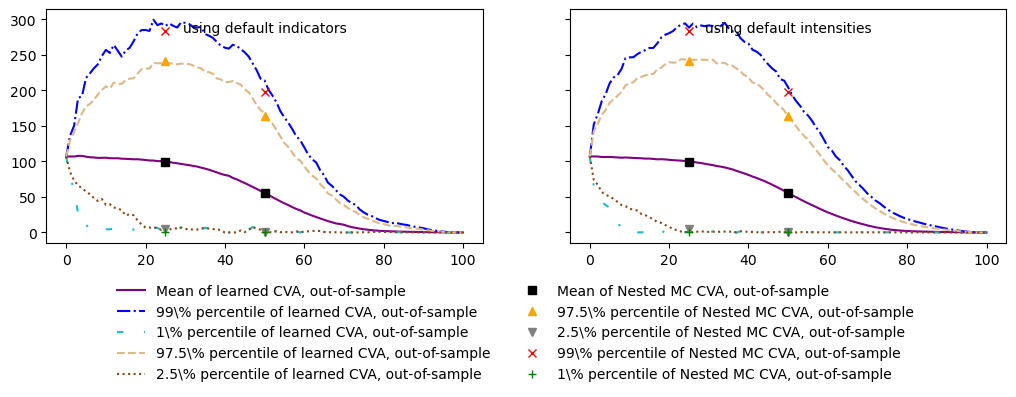

In [47]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 3), dpi=100)
axes[0].plot(predicted_cva_portfolio_def_out.mean(axis=1), label='Mean of learned CVA, out-of-sample', color='purple')
axes[0].plot(np.percentile(predicted_cva_portfolio_def_out, 99, axis=1), label=r'99\% percentile of learned CVA, out-of-sample', color='blue', linestyle='dashdot')
axes[0].plot(np.percentile(predicted_cva_portfolio_def_out, 1, axis=1), label=r'1\% percentile of learned CVA, out-of-sample', color='tab:cyan', linestyle=(0, (3, 10, 1, 10)))
axes[0].plot(np.percentile(predicted_cva_portfolio_def_out, 97.5, axis=1), label=r'97.5\% percentile of learned CVA, out-of-sample', color='burlywood', linestyle='dashed')
axes[0].plot(np.percentile(predicted_cva_portfolio_def_out, 2.5, axis=1), label=r'2.5\% percentile of learned CVA, out-of-sample', color='saddlebrown', linestyle='dotted')
axes[0].plot(nested_timesteps, diffusion_engine.nested_cva[nested_timesteps, 0].mean(axis=1), marker='s', linestyle='None', label='Mean of Nested Monte-Carlo CVA, out-of-sample', color='black')
axes[0].plot(nested_timesteps, np.percentile(diffusion_engine.nested_cva[nested_timesteps, 0], 97.5, axis=1), marker='^', linestyle='None', label=r'97.5\% percentile of Nested Monte-Carlo CVA, out-of-sample', color='orange')
axes[0].plot(nested_timesteps, np.percentile(diffusion_engine.nested_cva[nested_timesteps, 0], 2.5, axis=1), marker='v', linestyle='None', label=r'2.5\% percentile of Nested Monte-Carlo CVA, out-of-sample', color='gray')
axes[0].plot(nested_timesteps, np.percentile(diffusion_engine.nested_cva[nested_timesteps, 0], 99, axis=1), marker='x', linestyle='None', label=r'99\% percentile of Nested Monte-Carlo CVA, out-of-sample', color='red')
axes[0].plot(nested_timesteps, np.percentile(diffusion_engine.nested_cva[nested_timesteps, 0], 1, axis=1), marker='+', linestyle='None', label=r'1\% percentile of Nested Monte-Carlo CVA, out-of-sample', color='green')
axes[0].text(.5, .9,'using default indicators', horizontalalignment='center', transform=axes[0].transAxes)
axes[1].plot(predicted_cva_portfolio_int_out.mean(axis=1), label='Mean of learned CVA, out-of-sample', color='purple')
axes[1].plot(np.percentile(predicted_cva_portfolio_int_out, 99, axis=1), label=r'99\% percentile of learned CVA, out-of-sample', color='blue', linestyle='dashdot')
axes[1].plot(np.percentile(predicted_cva_portfolio_int_out, 1, axis=1), label=r'1\% percentile of learned CVA, out-of-sample', color='tab:cyan', linestyle=(0, (3, 10, 1, 10)))
axes[1].plot(np.percentile(predicted_cva_portfolio_int_out, 97.5, axis=1), label=r'97.5\% percentile of learned CVA, out-of-sample', color='burlywood', linestyle='dashed')
axes[1].plot(np.percentile(predicted_cva_portfolio_int_out, 2.5, axis=1), label=r'2.5\% percentile of learned CVA, out-of-sample', color='saddlebrown', linestyle='dotted')
axes[1].plot(nested_timesteps, diffusion_engine.nested_cva[nested_timesteps, 0].mean(axis=1), marker='s', linestyle='None', label='Mean of Nested MC CVA, out-of-sample', color='black')
axes[1].plot(nested_timesteps, np.percentile(diffusion_engine.nested_cva[nested_timesteps, 0], 97.5, axis=1), marker='^', linestyle='None', label=r'97.5\% percentile of Nested MC CVA, out-of-sample', color='orange')
axes[1].plot(nested_timesteps, np.percentile(diffusion_engine.nested_cva[nested_timesteps, 0], 2.5, axis=1), marker='v', linestyle='None', label=r'2.5\% percentile of Nested MC CVA, out-of-sample', color='gray')
axes[1].plot(nested_timesteps, np.percentile(diffusion_engine.nested_cva[nested_timesteps, 0], 99, axis=1), marker='x', linestyle='None', label=r'99\% percentile of Nested MC CVA, out-of-sample', color='red')
axes[1].plot(nested_timesteps, np.percentile(diffusion_engine.nested_cva[nested_timesteps, 0], 1, axis=1), marker='+', linestyle='None', label=r'1\% percentile of Nested MC CVA, out-of-sample', color='green')
axes[1].text(.5, .9,'using default intensities', horizontalalignment='center', transform=axes[1].transAxes)

fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)
lgd = axes.flatten()[-1].legend(loc='upper center', bbox_to_anchor=(-0.125, -0.12), ncol=2, frameon=False)